# Space Ship Project
This dataset was made to test the notebook, which I divided into two parts. In the first part, we process gaps, make new features, and glue the training and test dataset into one whole (while the target feature is stored separately). In the second part, you need to create a model and it was convenient for me to put the data in a separate dataset,
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

- test.csv original training dataset from the task
- train.csv original test dataset from the task
- train_target.csv original passenger crossing column
- train_test_clear.csv combined dataset from training and test, in which all transformations are done and there are no gaps
- sample_submission.csv response template

In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# importing models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# loading train and test dataset
train_df=pd.read_csv(r'space_ship_train.csv')
test_df=pd.read_csv(r'space_ship_test.csv')

In [332]:
# adding target column in test data 'Transported' with column value 0
if 'Transported' not in test_df.columns:
    test_df['Transported']=0

In [333]:
# concat the train and test dataset
df=pd.concat([train_df,test_df],axis=0)

In [334]:
# check the is data concat perfect
df.size==train_df.size+test_df.size  #if true perfect concat else not

True

In [335]:
# droping unnecessary columns 'Name' and PassengerId take as index value
df=df.set_index('PassengerId') #  set index value
df=df.drop(['Name'],axis=1) # droping column

In [336]:
df.head()

HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                         
0001_01         Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
0002_01          Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
0003_02         Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
0004_01          Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported  
PassengerId                                                                     
0001_01              0.0        0.0           0.0     0.0     0.0            0  
0002_01            109.0        9.0          25.0   549.0    44.0            1  
0003_01             43.0     3576.0           0.0  6715.0    49.0            0  
0003_02              0.0     1283.0         371.0  3329.0   193.0            0  
0004_01            303.0       70.0         151.0   565.0     2.0            1

In [337]:
df.shape

(12970, 12)

- Total 12970 rows and 14 columns

In [338]:
df.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  12700.000000  12707.000000  12681.000000  12664.000000  12686.000000   
mean      28.771969    222.897852    451.961675    174.906033    308.476904   
std       14.387261    647.596664   1584.370747    590.558690   1130.279641   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.000000      0.000000      0.000000      0.000000      0.000000   
50%       27.000000      0.000000      0.000000      0.000000      0.000000   
75%       38.000000     49.000000     77.000000     29.000000     57.000000   
max       79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck   Transported  
count  12702.000000  12970.000000  
mean     306.789482      0.337548  
std     1180.097223      0.472892  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%       42.000000      1.000000  
max    24133.000000      1.000000

# Data Preprocessing

In [339]:
# seperate the cabin values into new cols 
df[['deck','num','side']]=df['Cabin'].str.split('/',expand=True)
df=df.drop('Cabin',axis=1) # droping 'cabin' column after expand

In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0001_01 to 9277_01
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12682 non-null  object 
 1   CryoSleep     12660 non-null  object 
 2   Destination   12696 non-null  object 
 3   Age           12700 non-null  float64
 4   VIP           12674 non-null  object 
 5   RoomService   12707 non-null  float64
 6   FoodCourt     12681 non-null  float64
 7   ShoppingMall  12664 non-null  float64
 8   Spa           12686 non-null  float64
 9   VRDeck        12702 non-null  float64
 10  Transported   12970 non-null  int64  
 11  deck          12671 non-null  object 
 12  num           12671 non-null  object 
 13  side          12671 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 1.5+ MB


- Object columns are : HomePlanet, CryoSleep, Destination ,Deck ,num, side, VIP - (8)
- Numeric columns are : Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Transported - (6)

In [341]:
# no of unique values in each column
df.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1578
FoodCourt       1953
ShoppingMall    1367
Spa             1679
VRDeck          1642
Transported        2
deck               8
num             1894
side               2
dtype: int64

In [342]:
# conver data type of 'num' column to the numeric
df['num'] = pd.to_numeric(df['num'], errors='coerce')

In [343]:
# object and numerical columns
obj_cols=df.select_dtypes(include='object').columns
num_cols=df.select_dtypes(include='number').columns
obj_cols,num_cols

(Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side'], dtype='object'),
 Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'Transported', 'num'],
       dtype='object'))

In [344]:
# filling null values catgorical with mode and numerical data with mean
for col in obj_cols:
    mode=df[col].mode()[0]
    df[col]=df[col].fillna(mode)

for col in num_cols:
    mean=df[col].mean()
    df[col]=df[col].fillna(mean)

# Exploratory Data Analysis

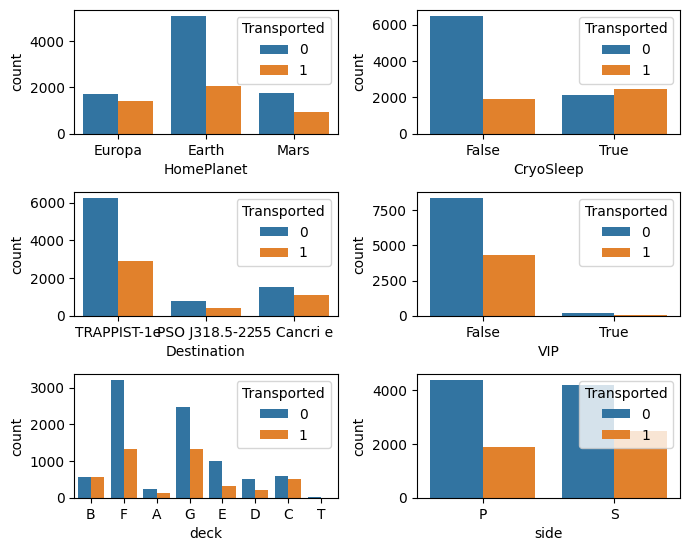

In [345]:
# count plot for the object columns
plt.figure(figsize=(7,7))
for i,col in enumerate(obj_cols,1):
    plt.subplot((len(obj_cols)+3)//2,2,i)
    sns.countplot(x=col,data=df,hue='Transported')
    plt.tight_layout()
plt.show()

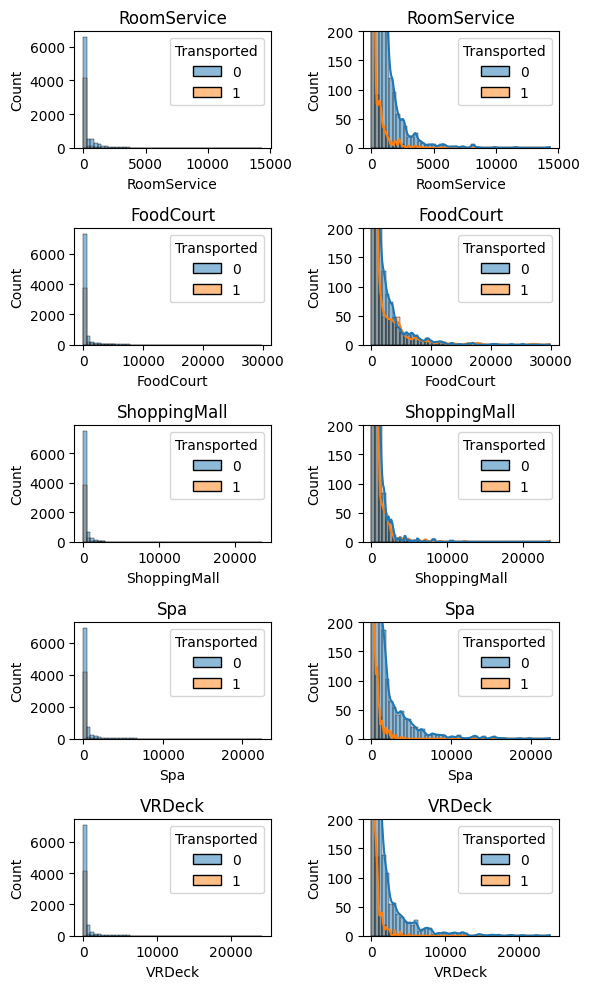

In [346]:
exp_feats=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
fig=plt.figure(figsize=(6,10))
for i,col in enumerate(exp_feats):
    # left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(x=col,hue='Transported',data=df,axes=ax,bins=50,kde=False)
    ax.set_title(col)
    
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(x=col,hue='Transported',data=df,axes=ax,bins=50,kde=True)
    plt.ylim([0,200])
    ax.set_title(col)
fig.tight_layout()
plt.show()

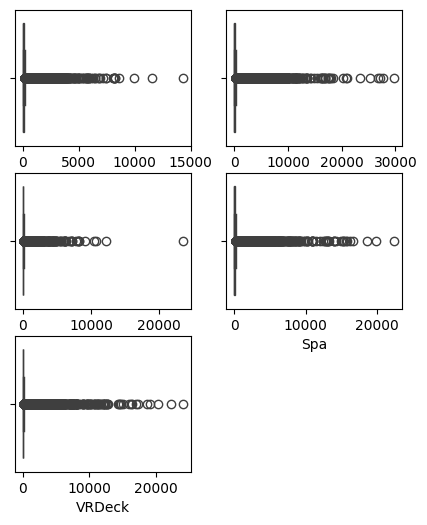

In [347]:
# Finding outliers by Box plot 
exp_feats=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
fig=plt.figure(figsize=(5,6))
for i,col in enumerate(exp_feats,1):
    plt.subplot((len(exp_feats)+2)//2,2,i)
    sns.boxplot(x=col,data=df)
    ax.set_title(col)

- in the Box plot every column data has many outliers

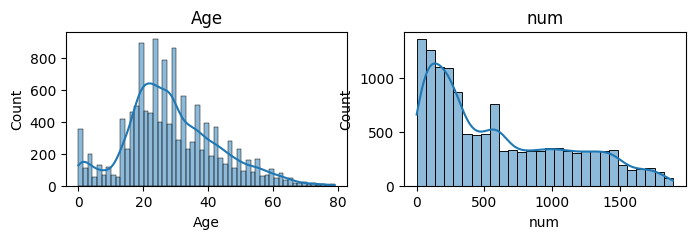

In [348]:
plt.figure(figsize=(8,2))
for i,col in enumerate(['Age','num'],1):
    plt.subplot(1,2,i)
    sns.histplot(x=col,data=df,kde=True)
    plt.title(f'{col}')

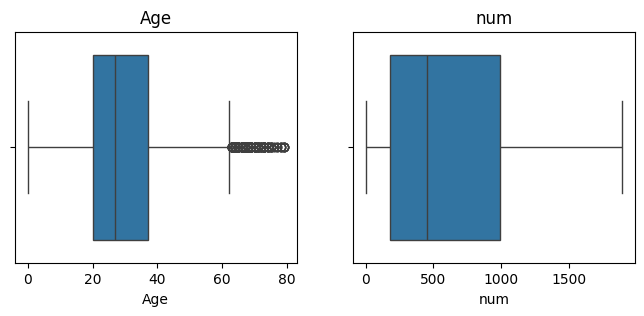

In [349]:
plt.figure(figsize=(8,3))
for i,col in enumerate(['Age','num'],1):
    plt.subplot(1,2,i)
    sns.boxplot(x=col,data=df)
    plt.title(f'{col}')

- Age has Outlier on Upper Bound and Num is a deck which is don't have outliers

In [350]:
# label encoding
df['HomePlanet']=df['HomePlanet'].map({'Earth':0,'Europa':1,'Mars':2})
df['Destination']=df['Destination'].map({'TRAPPIST-1e':0,'55 Cancri e':1,'PSO J318.5-22':2})
df['side']=df['side'].map({'S':0,'P':1})
df['deck']=df['deck'].map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'T':7})

<Axes: >

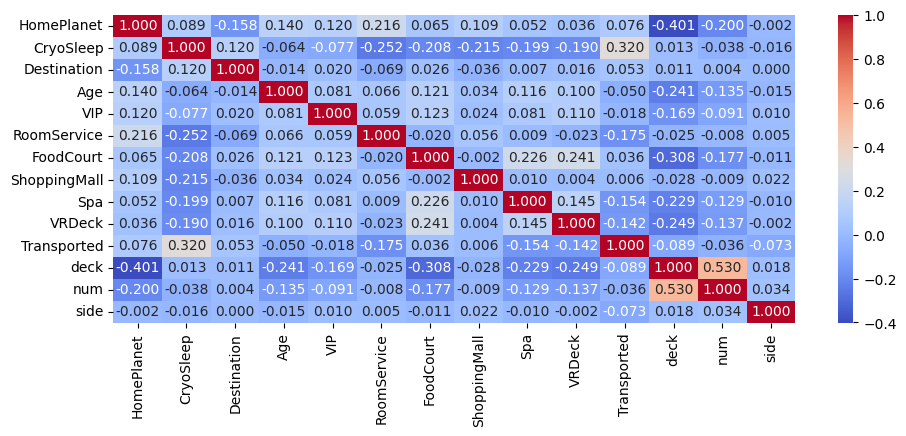

In [351]:
# correlation of dataset
corr=df.corr()
plt.figure(figsize=(11,4))
sns.heatmap(corr,cmap='coolwarm',fmt='.3f',annot=True)

- in the histogram deck <-> HomePlanet are correlated with 40.1%
- deck <-> num are correlated with 53%
- deck <-> foodCourt correlated with 30.8% etc.

In [352]:
# correlation with Traget columns('Transported'_ column
abs(df.corr()['Transported']).sort_values(ascending=False) # descending order of correlation

Transported     1.000000
CryoSleep       0.319534
RoomService     0.174588
Spa             0.154332
VRDeck          0.142008
deck            0.088749
HomePlanet      0.076344
side            0.073463
Destination     0.052661
Age             0.050247
num             0.035980
FoodCourt       0.035954
VIP             0.018345
ShoppingMall    0.005867
Name: Transported, dtype: float64

- CryoSleep has high correlation 31%
- RoomService,Spa,VRDeck has More than 10% correlation
- deck, HomePlanet, side, Destination,Age has More than 5% correlation
- num, Foodcourt,VIP,ShopingMall less correlation

In [353]:
# get features and traget columns values from dataset where which is train data
x=df.drop('Transported',axis=1).iloc[:len(train_df)]  
y=df['Transported'].iloc[:len(train_df)]

# Model Training

In [354]:
# splitting the x and y into train and test data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [355]:
x_train.shape,x_test.shape

((6954, 13), (1739, 13))

In [356]:
# scaling the features it scale the values  0 to +1 range
scaler=MinMaxScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [357]:
lr=LogisticRegression()
dt=DecisionTreeClassifier()
models={
    'Logistic Regression':LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boosting':GradientBoostingClassifier(),
    'Svm':SVC(),
    'xgb':XGBClassifier(),
    'catboost':CatBoostClassifier()
}

In [358]:
scores={'Model':[],'Score':[]}
for name,model in models.items():
    model.fit(x_train_scaled,y_train)
    ypred=model.predict(x_test_scaled)
    score=accuracy_score(y_test,ypred)
    scores['Model'].append(name)
    scores['Score'].append(score)
    print(f'{name} :{score}')
    

Logistic Regression :0.7538815411155837
Decision Tree :0.753306497987349
Random Forest :0.8102357676825762
Gradient Boosting :0.8021851638872916
Svm :0.7561817136285222
xgb :0.8113858539390454
Learning rate set to 0.023581
0:	learn: 0.6811307	total: 9.65ms	remaining: 9.64s
1:	learn: 0.6726706	total: 18.1ms	remaining: 9.01s
2:	learn: 0.6630876	total: 26.6ms	remaining: 8.83s
3:	learn: 0.6537045	total: 34.3ms	remaining: 8.55s
4:	learn: 0.6441833	total: 43.1ms	remaining: 8.57s
5:	learn: 0.6369996	total: 51.5ms	remaining: 8.53s
6:	learn: 0.6281808	total: 60.7ms	remaining: 8.61s
7:	learn: 0.6185958	total: 68.1ms	remaining: 8.44s
8:	learn: 0.6115653	total: 75.1ms	remaining: 8.27s
9:	learn: 0.6048699	total: 82.7ms	remaining: 8.19s
10:	learn: 0.5990015	total: 91ms	remaining: 8.18s
11:	learn: 0.5925367	total: 98.9ms	remaining: 8.14s
12:	learn: 0.5859487	total: 107ms	remaining: 8.12s
13:	learn: 0.5795452	total: 115ms	remaining: 8.07s
14:	learn: 0.5748710	total: 122ms	remaining: 8s
15:	learn: 0.56

In [359]:
# scores of each model
score_df=pd.DataFrame(scores)
score_df=score_df.sort_values(by='Score',ascending=False)
score_df

Model     Score
6             catboost  0.814836
5                  xgb  0.811386
2        Random Forest  0.810236
3    Gradient Boosting  0.802185
4                  Svm  0.756182
0  Logistic Regression  0.753882
1        Decision Tree  0.753306

In [360]:
model=models[score_df['Model'].iloc[0]]
model.fit(x_train_scaled,y_train)
ypred=model.predict(x_test_scaled)

Learning rate set to 0.023581
0:	learn: 0.6811307	total: 10.9ms	remaining: 10.9s
1:	learn: 0.6726706	total: 22.9ms	remaining: 11.4s
2:	learn: 0.6630876	total: 35.2ms	remaining: 11.7s
3:	learn: 0.6537045	total: 47.2ms	remaining: 11.7s
4:	learn: 0.6441833	total: 58.5ms	remaining: 11.6s
5:	learn: 0.6369996	total: 70.9ms	remaining: 11.7s
6:	learn: 0.6281808	total: 81.1ms	remaining: 11.5s
7:	learn: 0.6185958	total: 94.4ms	remaining: 11.7s
8:	learn: 0.6115653	total: 105ms	remaining: 11.6s
9:	learn: 0.6048699	total: 115ms	remaining: 11.3s
10:	learn: 0.5990015	total: 123ms	remaining: 11.1s
11:	learn: 0.5925367	total: 131ms	remaining: 10.8s
12:	learn: 0.5859487	total: 139ms	remaining: 10.6s
13:	learn: 0.5795452	total: 146ms	remaining: 10.3s
14:	learn: 0.5748710	total: 154ms	remaining: 10.1s
15:	learn: 0.5686750	total: 164ms	remaining: 10.1s
16:	learn: 0.5628119	total: 172ms	remaining: 9.95s
17:	learn: 0.5585018	total: 180ms	remaining: 9.79s
18:	learn: 0.5548661	total: 188ms	remaining: 9.7s
19:	

In [361]:
# classification report  precision,recall,f1score,accuracy_score
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       863
           1       0.81      0.82      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [362]:
# confusion matrix
confusion_matrix(y_test,ypred)

array([[700, 163],
       [159, 717]], dtype=int64)

# Hyper parameter

In [363]:
# define parameter gird
param_grid={
    'n_estimators':[i for i in range(10,200,30) ],
    'learning_rate':[0.01,0.1,0.2,0.5],
    'max_depth':[2,3,6],
    'subsample':[0.8,1.0]
}

In [364]:
grid_xgb=GridSearchCV(models['xgb'],param_grid,cv=10,scoring='accuracy',n_jobs=-1)
grid_xgb.fit(x_train_scaled,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=No...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [2, 3, 6],
                         'n_estimators': [10, 40, 70, 100, 130, 160, 190],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [365]:
# Best Model
best_model=grid_xgb.best_estimator_
ypred=best_model.predict(x_test_scaled)
accuracy_score(y_test,ypred) # accuracy Score

0.8067855089131685

In [366]:
# classification report  precision,recall,f1score,accuracy_score
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       863
           1       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [367]:
# confusion matrix
confusion_matrix(y_test,ypred)

array([[681, 182],
       [154, 722]], dtype=int64)

In [368]:
# False Positive Rate and True Positive Rate
y_score=best_model.predict_proba(x_test_scaled)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_score)

In [369]:
fpr[:10],tpr[:10],thresholds[:10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.00114155, 0.00799087, 0.01141553, 0.01598174,
        0.01940639, 0.0239726 , 0.02625571, 0.02968037, 0.03196347]),
 array([       inf, 0.9956909 , 0.9917891 , 0.99148834, 0.9907156 ,
        0.99069715, 0.990516  , 0.9904845 , 0.99013734, 0.99011457],
       dtype=float32))

In [370]:
# AUC Score
auc=roc_auc_score(y_test,y_score)
auc

0.9055950623554871

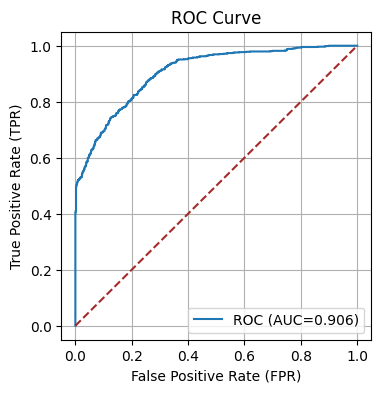

In [371]:
plt.figure(figsize=(4,4))
plt.plot(fpr,tpr,label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],linestyle='--',color='brown')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.grid()
plt.legend()
plt.show()

- The roc curve is 0.906

In [372]:
# submission data
sub_x=df.drop('Transported',axis=1).iloc[len(train_df):]
y_predict=best_model.predict(sub_x)
submission_df=pd.DataFrame()
submission_df['PassengerId']=test_df['PassengerId']
submission_df['Transported']=y_predict

In [373]:
submission_df.to_csv('submission.csv',index=False)

In [374]:
# cleaned datasets
df.to_csv('train_test_clean.csv',index=False)